In [28]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (16, 8)

import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import time
import warnings
warnings.filterwarnings("ignore")

In [29]:
print('loaded ' + str(len(redd.buildings)) + ' buildings')

loaded 6 buildings


In [30]:
redd = DataSet('data/REDD/redd.h5')
print_dict(redd.metadata)

In [31]:
#dividing data into train and test set
train = DataSet('data/REDD/redd.h5')
test = DataSet('data/REDD/redd.h5')

In [32]:
building = 1
#split data at april 30th and using building 1
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


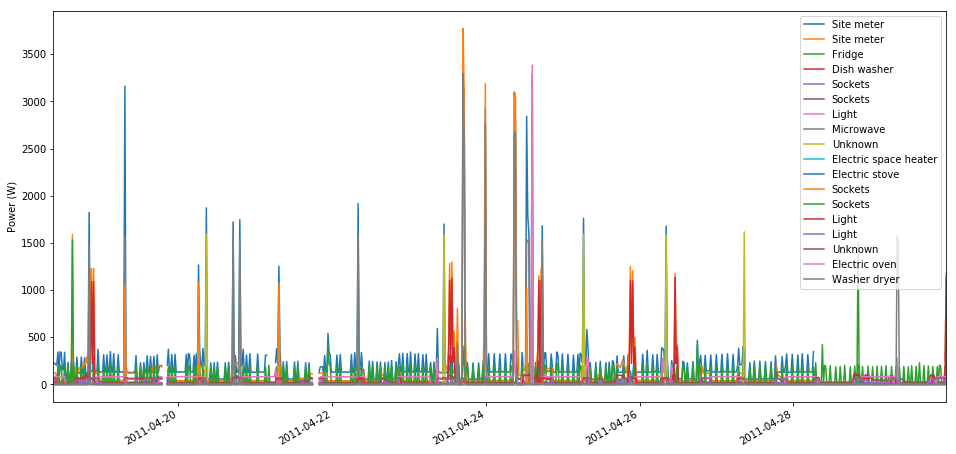

In [33]:
train_elec.plot()

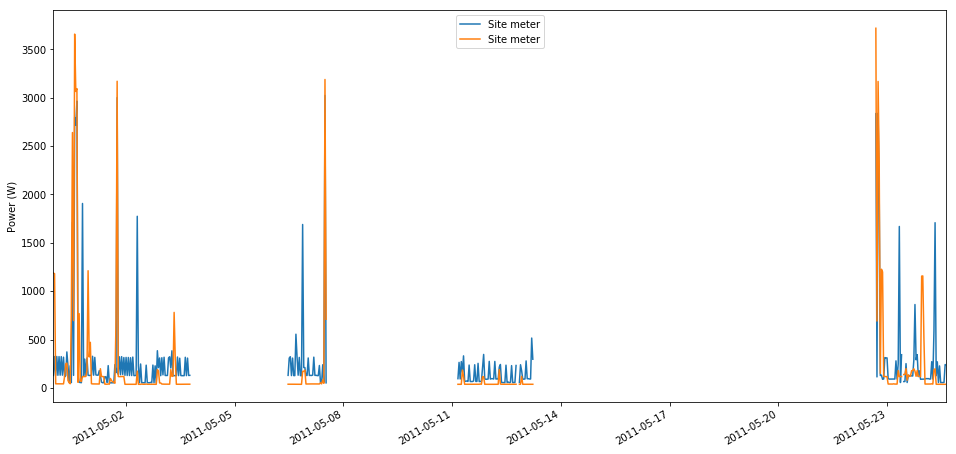

In [52]:
test_elec.mains().plot()

In [35]:
mains = train_elec.mains()

In [36]:
mains_df = mains.load().next()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [37]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


In [38]:
#selecting top-5 appliances
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=10, building=1, dataset='REDD') ...    total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [39]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

In [41]:
#training and disaggregation
#FHMM
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
('Runtime =', 14.21966004371643, 'seconds.')


In [42]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [43]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [44]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [45]:
local_timezone = train.metadata['timezone']

In [46]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [47]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [48]:
gt_overall.head()

,"ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])","ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])","ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])","ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])"
2011-04-30 00:01:00-04:00,1131.0,31.0,6.0,76.0,4.0
2011-04-30 00:02:00-04:00,1128.0,29.0,6.0,76.0,4.0
2011-04-30 00:03:00-04:00,1133.0,28.0,6.0,76.0,4.0
2011-04-30 00:04:00-04:00,1129.0,28.0,6.0,77.0,4.0
2011-04-30 00:05:00-04:00,1130.0,28.0,6.0,76.0,4.0


In [49]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [50]:
pred_overall.head()

,Dish washer,Sockets,Fridge,Light,Microwave
2011-04-30 00:01:00-04:00,0.0,22.0,192.0,2.0,1091.0
2011-04-30 00:02:00-04:00,0.0,22.0,192.0,2.0,1091.0
2011-04-30 00:03:00-04:00,0.0,22.0,192.0,2.0,1091.0
2011-04-30 00:04:00-04:00,0.0,22.0,192.0,2.0,1091.0
2011-04-30 00:05:00-04:00,0.0,22.0,192.0,2.0,1091.0


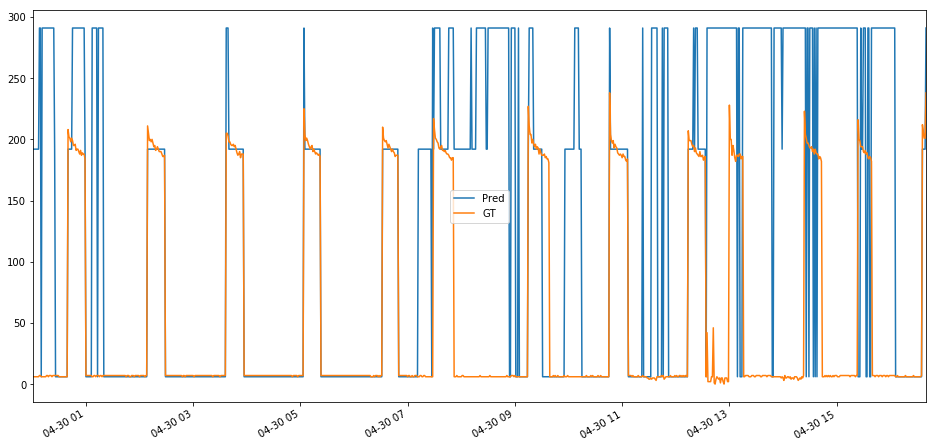

In [51]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()